#### Import Necessary Libraries

In [181]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # "jax" or "tensorflow" or "torch"

import keras_cv
import keras
import keras.backend as K
import tensorflow as tf
import numpy as np
import pandas as pd

from glob import glob
from tqdm import tqdm

import librosa
import IPython.display as ipd
import librosa.display as lid

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as ply
import ipywidgets as widgets
import seaborn as sns

import tensorflow_hub as hub
import tensorflow_io as tfio

from itertools import cycle
# Set interactive backend
%matplotlib inline


cmap = mpl.cm.get_cmap('coolwarm')
sns.set_theme(style="white", palette=None)
color_pal = ply.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(ply.rcParams["axes.prop_cycle"].by_key()["color"])


/var/folders/m9/m7xl4h0s4dxcq7r_gtrcb8m80000gn/T/ipykernel_1338/2982298529.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


#### About YAMNet

YAMNet is a pre-trained neural network that employs the MobileNetV1 depthwise-separable convolution architecture. It can use an audio waveform as input and make independent predictions for each of the 521 audio events from the AudioSet corpus.

Internally, the model extracts "frames" from the audio signal and processes batches of these frames. This version of the model uses frames that are 0.96 second long and extracts one frame every 0.48 seconds .

The model accepts a 1-D float32 Tensor or NumPy array containing a waveform of arbitrary length, represented as single-channel (mono) 16 kHz samples in the range [-1.0, +1.0].

The model returns 3 outputs, including the class scores, embeddings (which you will use for transfer learning), and the log mel spectrogram.



In [182]:
### Load Dataset
DATASET_PATH = 'content/birdclef-2024'
## To handle our settings  and configurations, let's create a class
class Config:    
    #Yamnet Model
    sample_rate = 16000
    preset = 'https://tfhub.dev/google/yamnet/1'
    class_names = sorted(os.listdir(f'{DATASET_PATH}/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}
    # Define split ratios
    train_ratio = 0.8  # 80% for training
    val_ratio = 0.1    # 10% for validation
    test_ratio = 0.1   # 10% for testing 
    AUTOTUNE = tf.data.AUTOTUNE

### Load and Explore the dataset

In [183]:
df = pd.read_csv(f'{DATASET_PATH}/train_metadata.csv')
df['filepath'] = DATASET_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(Config.name2label)
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

## display a few rows of the dataframe
df = df.sample(frac=1, random_state=42)
df.head(5)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,xc_id
3265,blrwar1,[],"['male', 'song']",50.4140,60.6285,Acrocephalus dumetorum,Blyth's Reed Warbler,Albert Lastukhin,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/184748,XC184748.ogg,content/birdclef-2024/train_audio/blrwar1/XC18...,20,XC184748
23387,whtkin2,[],[''],11.9632,75.5785,Halcyon smyrnensis,White-throated Kingfisher,JISHNU KIZHAKKILLAM,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://xeno-canto.org/797017,XC797017.ogg,content/birdclef-2024/train_audio/whtkin2/XC79...,176,XC797017
14115,hoopoe,[],['song'],54.6929,28.2816,Upupa epops,Eurasian Hoopoe,Danuta Peplowska-Marczak,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/349675,XC349675.ogg,content/birdclef-2024/train_audio/hoopoe/XC349...,80,XC349675
12223,grnsan,[],"['NFC', 'Nocturnal flight call', 'flight call']",42.7285,2.9876,Tringa ochropus,Green Sandpiper,Quentin GIRAUDON,Creative Commons Attribution-NonCommercial-Sha...,2.0,https://www.xeno-canto.org/478932,XC478932.ogg,content/birdclef-2024/train_audio/grnsan/XC478...,71,XC478932
22099,tibfly3,[],"['duet', 'female', 'male', 'song']",8.9141,98.5096,Cyornis tickelliae,Tickell's Blue Flycatcher,Jelle Scharringa,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/645726,XC645726.ogg,content/birdclef-2024/train_audio/tibfly3/XC64...,161,XC645726


#### Function to load audio files, which will also be used later when working with the training data.

In [184]:
def load_ogg_16k_mono(filename):
    """
    Load an OGG file, convert it to a float tensor, and resample to 16 kHz single-channel audio.
    """
    # Load the OGG file using librosa
    wav, sample_rate = librosa.load(filename, sr=None, mono=True)  # sr=None preserves the original sample rate
    
    # Resample to 16 kHz using librosa
    target_sample_rate = 16000
    wav_resampled = librosa.resample(wav, orig_sr=sample_rate, target_sr=target_sample_rate)
    
    # Convert the NumPy array to a TensorFlow tensor
    wav_resampled = tf.convert_to_tensor(wav_resampled, dtype=tf.float32)
    
    return wav_resampled

In [185]:
### Test the function
df.filepath[0]
wav = load_ogg_16k_mono(df.filepath[0])
wav

<tf.Tensor: shape=(437604,), dtype=float32, numpy=
array([ 1.2875962e-06, -2.0156826e-06,  2.7679102e-06, ...,
        5.0798794e-06,  6.0164912e-06, -4.1922403e-06], dtype=float32)>

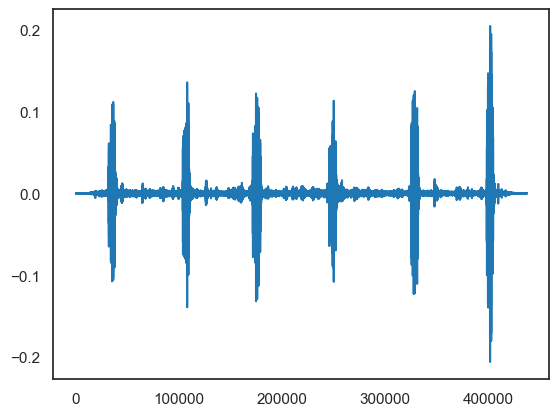

In [186]:
testing_wav_data = load_ogg_16k_mono(df.filepath[0])

_ = plt.plot(testing_wav_data)

# Play the audio file.
ipd.Audio(testing_wav_data, rate=16000)

#### Load the audio files and retrieve embeddings
Here you'll apply the load_wav_16k_mono and prepare the WAV data for the model.

When extracting embeddings from the WAV data, you get an array of shape (N, 1024) where N is the number of frames that YAMNet found (one for every 0.48 seconds of audio).

Your model will use each frame as one input. Therefore, you need to create a new column that has one frame per row. You also need to expand the labels and the fold column to proper reflect these new rows.

The expanded fold column keeps the original values. You cannot mix frames because, when performing the splits, you might end up having parts of the same audio on different splits, which would make your validation and test steps less effective.

In [187]:
# filenames = df['filepath']
# targets = df['target']
# main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets))
# main_ds.element_spec

# def load_ogg_for_map(filename, label):
#   return load_ogg_16k_mono(filename), label

# main_ds = main_ds.map(load_ogg_for_map)
# main_ds.element_spec

## I exprienced difficulty with the above code, so I used tf.py_function to load ogg files. This is slower. The alternative is to convert the ogg files to wav files.
# Wrap librosa.load in a tf.py_function

def load_ogg_for_map(filename, label):
    # Use tf.py_function to call librosa.load
    wav_resampled = tf.py_function(
        func=lambda f: load_ogg_16k_mono(f.numpy().decode('utf-8')),  # Convert tensor to string
        inp=[filename],  # Input tensor
        Tout=tf.float32  # Output tensor type
    )
    return wav_resampled, label

# Create the dataset
filenames = df['filepath']
targets = df['target']
main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets))

# Map the function to the dataset
main_ds = main_ds.map(load_ogg_for_map)

# Inspect the dataset
print(main_ds.element_spec)

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


### Exctracting Embeddings

In [188]:
## Load the Yamnet model
yamnet_model_handle = Config.preset
yamnet_model = hub.load(yamnet_model_handle)

In [189]:
# applies the embedding extraction model to a wav data
# Function to extract embeddings using YAMNet
def extract_embedding(wav_data, label):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings))

# Extract embeddings
main_ds = main_ds.map(extract_embedding).unbatch()

# Inspect the dataset
print(main_ds.element_spec)

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [190]:
# Image and audio parameters
batch_size = 64  # Batch size for training

def build_decoder(with_labels=True, dim=16000):
    def load_audio(filename, label=None):
        wav_resampled = tf.py_function(
            func=lambda f: load_ogg_16k_mono(f.numpy().decode('utf-8')),
            inp=[filename],
            Tout=tf.float32
        )
        wav_resampled.set_shape([None])  # Ensures dynamic shape handling
        if label is not None:
            return wav_resampled, label
        return wav_resampled
    
    def crop_or_pad(audio, target_len, pad_mode="CONSTANT"):
        audio_len = tf.shape(audio)[0]
        diff_len = target_len - audio_len
        
        if diff_len > 0:
            pad_start = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad_end = diff_len - pad_start
            audio = tf.pad(audio, paddings=[[pad_start, pad_end]], mode=pad_mode)
        elif diff_len < 0:
            start = tf.random.uniform([], maxval=-diff_len, dtype=tf.int32)
            audio = audio[start : (start + target_len)]
        
        return tf.reshape(audio, [target_len])
    
    def extract_embedding(wav_data, label=None):
        scores, embeddings, spectrogram = yamnet_model(wav_data)
        num_embeddings = tf.shape(embeddings)[0]
        if label is not None:
            return embeddings, tf.repeat(label, num_embeddings)
        return embeddings
    
    def get_target(target):
        target = tf.one_hot(target, Config.num_classes)
        return tf.cast(target, tf.float32)
    
    def decode(path):
        audio = load_audio(path)
        audio = crop_or_pad(audio, dim)
        return extract_embedding(audio)
    
    def decode_with_labels(path, label):
        return decode(path), get_target(label)
    
    return decode_with_labels if with_labels else decode



In [191]:
def build_augmenter():
    def augment(audio):
        '''Applies augmentation like noise injection and time shift.'''
        noise = tf.random.normal(shape=tf.shape(audio), mean=0.0, stddev=0.005, dtype=tf.float32)
        audio = audio + noise
        shift = tf.random.uniform([], minval=-1000, maxval=1000, dtype=tf.int32)
        audio = tf.roll(audio, shift, axis=0)
        return audio
    return augment

In [192]:
def build_dataset(paths, labels, batch_size=32, shuffle=True, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    decoder = build_decoder(with_labels=True)
    dataset = dataset.map(decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    if augment:
        augmenter = build_augmenter()
        dataset = dataset.map(lambda x, y: (augmenter(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(2048)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [193]:
# Example usage
# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size=0.2)

print(f"Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

train_df, valid_df = train_test_split(df, test_size=0.2)

print(f"Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")


Num Train: 19567 | Num Valid: 4892
Num Train: 19567 | Num Valid: 4892


In [194]:
# Prepare training dataset
train_paths = train_df.filepath.values  # Extract file paths from training DataFrame
train_labels = train_df.target.values   # Extract corresponding labels

train_ds = build_dataset(
    paths=train_paths, 
    labels=train_labels, 
    batch_size=batch_size,
    shuffle=2048,  # Enable shuffling for training dataset
    augment=True  # Apply augmentation for training dataset
)

# Prepare validation dataset
valid_paths = valid_df.filepath.values  # Extract file paths from validation DataFrame
valid_labels = valid_df.target.values   # Extract corresponding labels

valid_ds = build_dataset(
    paths=valid_paths, 
    labels=valid_labels, 
    batch_size=batch_size,
    shuffle=False,  # No shuffling for validation to ensure consistency
    augment=False  # No augmentation for validation dataset
)

def aggregate_embeddings(embeddings, label):
    aggregated_embeddings = tf.reduce_mean(embeddings, axis=1)  # Shape: (batch_size, 1024)
    aggregated_embeddings.set_shape([None, 1024])  # Explicitly setting shape
    return aggregated_embeddings, label


# Apply aggregation and batch the datasets
train_ds = train_ds.map(aggregate_embeddings).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.map(aggregate_embeddings).prefetch(tf.data.AUTOTUNE)


In [195]:
# Inspect the shapes of the dataset
for batch in train_ds.take(1):
    embeddings, labels = batch
    print("Embeddings shape:", embeddings.shape)
    print("Labels shape:", labels.shape)

2025-02-17 16:53:34.709459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1330 of 2048
2025-02-17 16:53:39.134562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


Embeddings shape: (64, 1024)
Labels shape: (64, 182)


### Split the data set into test, train and infer datasets
Since we have no fold column, we split the data into 80% for training, 10% for validation and 10% for testing

### Create your model
Next, define a very simple Sequential model with one hidden layer and two outputs to recognize cats and dogs from sounds.




In [196]:
# audio_embedding_model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(1024,), dtype=tf.float32),  # Use a tuple for the shape
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(Config.num_classes)
# ], name='audio_embedding_model')
# Model Definition with Dropout & BatchNorm
audio_embedding_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(Config.num_classes, activation='softmax')  # Changed from logits output
])

audio_embedding_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 182)            │        46,774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705,974 (2.69 MB)

 Trainable params: 704,438 (2.69 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [197]:
# audio_embedding_model.compile(
#     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#     optimizer="adam",
#     metrics=['accuracy']
# )


# callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
#                                             patience=3,
#                                             restore_best_weights=True)

audio_embedding_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train Model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [198]:
# Repeat the datasets indefinitely

# Calculate steps_per_epoch and validation_steps
# batch_size = 32
# # Train the model
# history = audio_embedding_model.fit(train_ds,
#                        epochs=20,
#                        validation_data=valid_ds,
#                        callbacks=callback)
history = audio_embedding_model.fit(train_ds,
                                    epochs=30,  # Increased epochs for better learning
                                    validation_data=valid_ds,
                                    callbacks=[callback])

Epoch 1/30


2025-02-17 16:53:51.817279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1270 of 2048
2025-02-17 16:53:56.802058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 200s 601ms/step - accuracy: 0.0441 - loss: 5.2827 - val_accuracy: 0.1081 - val_loss: 4.3544
Epoch 2/30


2025-02-17 16:57:10.453094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1330 of 2048
2025-02-17 16:57:15.435003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 200s 605ms/step - accuracy: 0.1000 - loss: 4.4647 - val_accuracy: 0.1308 - val_loss: 4.1102
Epoch 3/30


2025-02-17 17:00:30.700672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1279 of 2048
2025-02-17 17:00:35.568280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 200s 604ms/step - accuracy: 0.1022 - loss: 4.2901 - val_accuracy: 0.1316 - val_loss: 3.9919
Epoch 4/30


2025-02-17 17:03:50.237416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1308 of 2048
2025-02-17 17:03:54.788883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 199s 603ms/step - accuracy: 0.1221 - loss: 4.1357 - val_accuracy: 0.1498 - val_loss: 3.9068
Epoch 5/30


2025-02-17 17:07:09.086259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1319 of 2048
2025-02-17 17:07:13.595859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 199s 602ms/step - accuracy: 0.1250 - loss: 4.0531 - val_accuracy: 0.1490 - val_loss: 3.8742
Epoch 6/30


2025-02-17 17:10:27.774278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1220 of 2048
2025-02-17 17:10:32.991587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 199s 600ms/step - accuracy: 0.1305 - loss: 3.9991 - val_accuracy: 0.1533 - val_loss: 3.8462
Epoch 7/30


2025-02-17 17:13:46.358277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1329 of 2048
2025-02-17 17:13:50.776766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 198s 599ms/step - accuracy: 0.1380 - loss: 3.9467 - val_accuracy: 0.1566 - val_loss: 3.8050
Epoch 8/30


2025-02-17 17:17:04.035352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1308 of 2048
2025-02-17 17:17:08.560447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 199s 602ms/step - accuracy: 0.1416 - loss: 3.9201 - val_accuracy: 0.1576 - val_loss: 3.7911
Epoch 9/30


2025-02-17 17:20:22.546751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1330 of 2048
2025-02-17 17:20:26.874028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 198s 602ms/step - accuracy: 0.1415 - loss: 3.8953 - val_accuracy: 0.1576 - val_loss: 3.7787
Epoch 10/30


2025-02-17 17:23:40.980330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1347 of 2048
2025-02-17 17:23:45.236730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 197s 597ms/step - accuracy: 0.1495 - loss: 3.8596 - val_accuracy: 0.1678 - val_loss: 3.7454
Epoch 11/30


2025-02-17 17:26:57.689494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1270 of 2048
2025-02-17 17:27:02.423484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 198s 600ms/step - accuracy: 0.1509 - loss: 3.8232 - val_accuracy: 0.1578 - val_loss: 3.7583
Epoch 12/30


2025-02-17 17:30:15.948802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1347 of 2048
2025-02-17 17:30:20.244749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 199s 604ms/step - accuracy: 0.1556 - loss: 3.8164 - val_accuracy: 0.1699 - val_loss: 3.7264
Epoch 13/30


2025-02-17 17:33:34.812670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1339 of 2048
2025-02-17 17:33:39.129128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 197s 599ms/step - accuracy: 0.1599 - loss: 3.8055 - val_accuracy: 0.1705 - val_loss: 3.7384
Epoch 14/30


2025-02-17 17:36:52.348409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1330 of 2048
2025-02-17 17:36:56.923915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 200s 605ms/step - accuracy: 0.1573 - loss: 3.7851 - val_accuracy: 0.1654 - val_loss: 3.7231
Epoch 15/30


2025-02-17 17:40:12.209698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1330 of 2048
2025-02-17 17:40:16.617020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 198s 601ms/step - accuracy: 0.1560 - loss: 3.7701 - val_accuracy: 0.1654 - val_loss: 3.7167
Epoch 16/30


2025-02-17 17:43:30.498329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1343 of 2048
2025-02-17 17:43:34.825684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 197s 598ms/step - accuracy: 0.1588 - loss: 3.7572 - val_accuracy: 0.1744 - val_loss: 3.7094
Epoch 17/30


2025-02-17 17:46:47.548239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1347 of 2048
2025-02-17 17:46:51.814117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 199s 603ms/step - accuracy: 0.1618 - loss: 3.7547 - val_accuracy: 0.1748 - val_loss: 3.7015
Epoch 18/30


2025-02-17 17:50:06.189285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1330 of 2048
2025-02-17 17:50:10.544919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 198s 601ms/step - accuracy: 0.1643 - loss: 3.7277 - val_accuracy: 0.1758 - val_loss: 3.6909
Epoch 19/30


2025-02-17 17:53:24.187128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1339 of 2048
2025-02-17 17:53:28.523989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 198s 601ms/step - accuracy: 0.1688 - loss: 3.7334 - val_accuracy: 0.1772 - val_loss: 3.6744
Epoch 20/30


2025-02-17 17:56:42.272407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1347 of 2048
2025-02-17 17:56:46.599384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 198s 601ms/step - accuracy: 0.1679 - loss: 3.7013 - val_accuracy: 0.1783 - val_loss: 3.6923
Epoch 21/30


2025-02-17 18:00:00.466162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1320 of 2048
2025-02-17 18:00:04.914623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 199s 602ms/step - accuracy: 0.1628 - loss: 3.7312 - val_accuracy: 0.1780 - val_loss: 3.6785
Epoch 22/30


2025-02-17 18:03:19.113478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1330 of 2048
2025-02-17 18:03:23.489594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 197s 598ms/step - accuracy: 0.1711 - loss: 3.7057 - val_accuracy: 0.1783 - val_loss: 3.6818
Epoch 23/30


2025-02-17 18:06:36.313447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1305 of 2048
2025-02-17 18:06:40.929287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 198s 601ms/step - accuracy: 0.1716 - loss: 3.6985 - val_accuracy: 0.1723 - val_loss: 3.6670
Epoch 24/30


2025-02-17 18:09:54.631535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1319 of 2048
2025-02-17 18:09:59.494956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 200s 607ms/step - accuracy: 0.1679 - loss: 3.7002 - val_accuracy: 0.1799 - val_loss: 3.6671
Epoch 25/30


2025-02-17 18:13:15.016577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1308 of 2048
2025-02-17 18:13:19.561586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 199s 605ms/step - accuracy: 0.1682 - loss: 3.6938 - val_accuracy: 0.1787 - val_loss: 3.6744
Epoch 26/30


2025-02-17 18:16:34.429442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1317 of 2048
2025-02-17 18:16:38.956192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 199s 602ms/step - accuracy: 0.1749 - loss: 3.6523 - val_accuracy: 0.1770 - val_loss: 3.6684
Epoch 27/30


2025-02-17 18:19:53.116965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1347 of 2048
2025-02-17 18:19:57.521531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 199s 603ms/step - accuracy: 0.1730 - loss: 3.6827 - val_accuracy: 0.1813 - val_loss: 3.6483
Epoch 28/30


2025-02-17 18:23:11.795249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1356 of 2048
2025-02-17 18:23:15.993044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 196s 595ms/step - accuracy: 0.1798 - loss: 3.6490 - val_accuracy: 0.1811 - val_loss: 3.6576
Epoch 29/30


2025-02-17 18:26:27.983703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1366 of 2048
2025-02-17 18:26:32.164683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 197s 598ms/step - accuracy: 0.1710 - loss: 3.6647 - val_accuracy: 0.1830 - val_loss: 3.6559
Epoch 30/30


2025-02-17 18:29:45.155735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:608: Filling up shuffle buffer (this may take a while): 1348 of 2048
2025-02-17 18:29:49.471549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


306/306 ━━━━━━━━━━━━━━━━━━━━ 197s 596ms/step - accuracy: 0.1771 - loss: 3.6494 - val_accuracy: 0.1783 - val_loss: 3.6482
